In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

from src.config import MODELS_DIR, URBAN_CLUSTER_FILE, CLUSTER_LABELS

# House pricing

This project has 2 main phases:


1. Initial
2. Rerun

Each of the phases contained such steps:


The second phase repeats the steps above with a slight modification. Instead of just collecting the data new features are also added/engineered from the existing data. Moreover, the cluster by the urbanization level was performed and the obtained labels were also added as a possible feature. 

## General setup

In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from src.config import (
    MASTER_DF_FILE,
    MASTER_DF0_FILE,
    YEARS,
    RANDOM_SEED,
    CLUSTERING_CONFIGS,
    URBAN_CLUSTER_FILE
)

from src.data.loader import DataLoader
from src.features.dimentionality import UrbanizationPCA
from src.models.clustering import ClusteringEngine


warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Phase 1

### Collecting and processing data

The directory [`notebooks/eda/`](notebooks/clustering/) contains more detailed notebooks on the data cleaning, preparation and EDA. 

---

Here's the result of that work: the master dataset, that contains all of the relevant data from 2 open APIs (Weather: [OpenMeteoAPI](https://open-meteo.com/en/docs/historical-weather-api) and amenities from [OpenStreetMapAPI](https://www.openstreetmap.org/#map=7/39.606/-7.839)) and 4 datasets (all obtained from the Pordata portal):
- Average house pricing
- Average income among people with total education level
- Population density
- Age distributions

As a result of the data manipulations the master dataset was created. It contains 28 columns, where:
- 2 columns indicate the average quarter house price (regular and log of the price)
- 3 temporal columns (`quarter_num`, `quarter_ord` and `year`), one of which (`year`) is mostly a helper/meta column
- 16 amenities columns
- 1 income column
- 5 weather columns
- 1 municipality name column (meta column)

The data in the dataset describes 230 municipalities, all on the NUTS4 level, for 4 whole years + 1 quarter, from the last quarter of 2019 till the end of 2023. 

> Combining the master dataset (look for the Phase 1 section) [`notebooks/eda/04_combine_master_dataset.ipynb`](notebooks/eda/04_combine_master_dataset.ipynb)

> Data cleaning: [`notebooks/eda/00_data_cleaning.ipynb`](notebooks/eda/00_data_cleaning.ipynb) and [`notebooks/eda/03_weather_age_features.ipynb`](notebooks/eda/03_weather_age_features.ipynb) for the weather data

> Initial EDA: [`notebooks/eda/01_eda.ipynb`](notebooks/eda/01_eda.ipynb)

In [15]:
df0 = pd.read_csv(MASTER_DF0_FILE, index_col=0)
df0.head()

,municipality,house_price,total_sunshine_h,mean_sunshine_h,windspeed_mean_kmh,total_precipitation_mm,mean_precipitation_mm,year,quarter_num,quarter_ord,...,library,mall,museum,pharmacy,police,post_office,school,station,theatre,university
0,Arcos de Valdevez,813.0,487.521214,5.299144,9.177174,1405.1,15.272826,2023,4,17,...,4.0,2.0,5.0,10.0,2.0,4.0,15.0,1.0,1.0,0.0
4,Paredes de Coura,723.0,472.135439,5.131907,10.283696,1237.1,13.446739,2023,4,17,...,1.0,0.0,1.0,4.0,1.0,1.0,7.0,1.0,0.0,0.0
5,Ponte da Barca,759.0,499.030875,5.424249,8.804348,1300.5,14.135870,2023,4,17,...,3.0,2.0,7.0,10.0,2.0,3.0,16.0,1.0,1.0,0.0
6,Ponte de Lima,1128.0,513.344253,5.579829,11.211957,1132.9,12.314130,2023,4,17,...,2.0,2.0,3.0,13.0,6.0,2.0,39.0,2.0,1.0,2.0
7,Valença,945.0,549.046297,5.967895,13.494565,386.7,4.203261,2023,4,17,...,3.0,1.0,3.0,7.0,6.0,4.0,23.0,5.0,1.0,1.0


The initial assumptions from the beginning and after the initial EDA ([`notebooks/eda/01_eda.ipynb`](notebooks/eda/01_eda.ipynb)) include that the key drivers for the house pricing were income and amenities. We're also aware of the geographical specifics of Portugal, so to align with it we also considered the assumption that wind could be one the key factors, since windspeed is higher closer to the coastal line.

### Modeling

## Phase 2

### Adding more data

With the addition of 2 datasets (age distribution and density, more detailed in [`notebooks/eda/02_eda_add.ipynb`](notebooks/eda/02_eda_add.ipynb)) and engineered features ([`notebooks/eda/03_weather_age_features.ipynb`](notebooks/eda/03_weather_age_features.ipynb)), the master dataset became fairly bigger (+ 11 features). Newly added information includes 6 age bucket columns, 1 population density column and 4 comfort weather features.

The comfort weather feature criteria were picked solely by us so the features are not really a reliale source of information. Yet we've added them in order to experiment whether the overall feature of quality of life would make a change.

In [16]:
df1 = pd.read_csv(MASTER_DF_FILE, index_col=0)
df1.head()

,municipality,house_price,total_sunshine_h,mean_sunshine_h,windspeed_mean_kmh,total_precipitation_mm,mean_precipitation_mm,windy_days,rainy_days,sunny_days,...,library,mall,museum,pharmacy,police,post_office,school,station,theatre,university
0,Arcos de Valdevez,813.0,487.521214,5.299144,9.177174,1405.1,15.272826,0,57,34,...,4.0,2.0,5.0,10.0,2.0,4.0,15.0,1.0,1.0,0.0
4,Paredes de Coura,723.0,472.135439,5.131907,10.283696,1237.1,13.446739,0,57,34,...,1.0,0.0,1.0,4.0,1.0,1.0,7.0,1.0,0.0,0.0
5,Ponte da Barca,759.0,499.030875,5.424249,8.804348,1300.5,14.135870,0,57,35,...,3.0,2.0,7.0,10.0,2.0,3.0,16.0,1.0,1.0,0.0
6,Ponte de Lima,1128.0,513.344253,5.579829,11.211957,1132.9,12.314130,2,58,38,...,2.0,2.0,3.0,13.0,6.0,2.0,39.0,2.0,1.0,2.0
7,Valença,945.0,549.046297,5.967895,13.494565,386.7,4.203261,1,54,27,...,3.0,1.0,3.0,7.0,6.0,4.0,23.0,5.0,1.0,1.0


### Modeling

### Clustering

The idea behind it was to try to distinguish the clusters based on the urbanization or development level of the municipality. Amenities, average income and population density were chosen to be the features to describe the urbanization level. For the vizualization the PCA was used, as a result of which 2 PCs were used. The second PC is heavily weighted on the income and density, thus it is marked as _Wealth and Density_ on the plots, while the first PC preserves the most of the variance of the infrastructure per municipality. 

Before the clustering the visualization of the data (extended master dataset, `df1`, with the selected features) was visualized yearly in order to see whether exists a significant change that would require us to perform more complex clustering analysis. The inspection of the obtained plots led us to the conclusion that we could safely pick one of the years (2020-2023) and train the KMeans model in order to retrieve the cluster label that we could later expand on the whole dataset. 

>  Full clustering story: [`notebooks/clustering/01_urbanization_clustering_all.ipynb`](notebooks/clustering/01_urbanization_clustering_all.ipynb)

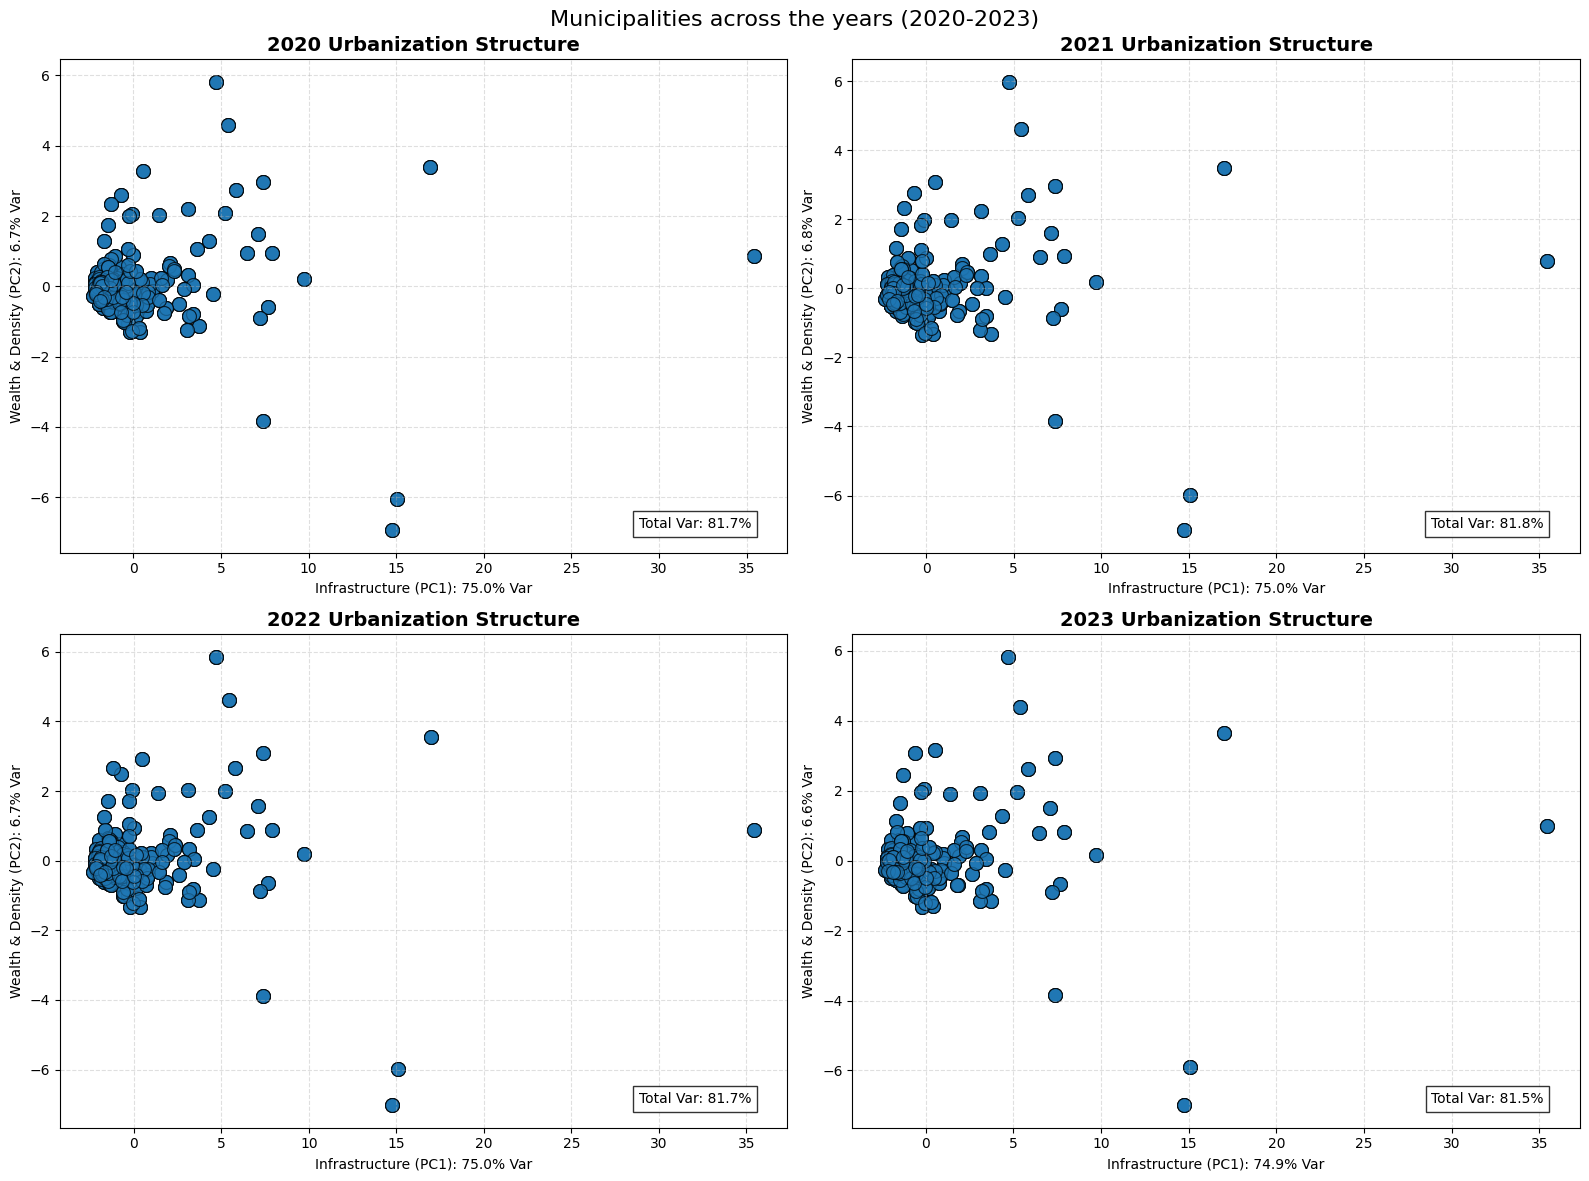

In [23]:
EXP_KEY = "urban"
config = CLUSTERING_CONFIGS[EXP_KEY]

loader = DataLoader(MASTER_DF_FILE)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten to make indexing (0, 1, 2, 3) easier

for i, year in enumerate(YEARS):
    ax = axes[i]
    
    try:
        df_year = loader.get_data_for_year(year, features=config["features"])
        
        if df_year.empty:
            ax.text(0.5, 0.5, f"No Data for {year}", ha='center', fontsize=14)
            continue

        analyzer = UrbanizationPCA(n_components=2)
        pca_tmp_df = analyzer.run_pca(df_year)
        stats = analyzer.get_variance_stats()
        
        sns.scatterplot(
            x='PC1', 
            y='PC2', 
            data=pca_tmp_df, 
            ax=ax, 
            s=100, 
            alpha=0.7, 
            edgecolor='k',
            legend=False
        )
        
        ax.set_title(f"{year} Urbanization Structure", fontsize=14, weight='bold')
        ax.set_xlabel(f"Infrastructure (PC1): {stats['pc1_var']:.1f}% Var")
        ax.set_ylabel(f"Wealth & Density (PC2): {stats['pc2_var']:.1f}% Var")
        ax.grid(True, linestyle="--", alpha=0.4)
        
        # Add total variance annotation
        ax.text(0.95, 0.05, f"Total Var: {stats['total_var']:.1f}%", 
                transform=ax.transAxes, ha='right', fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8))

    except Exception as e:
        ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', color='red')

fig.suptitle("Municipalities across the years (2020-2023)", fontsize=16)

plt.tight_layout()
plt.show()

Since we've seen that there's no significant difference between years, we'll take the data from 2022 to obtain the clusters. We'll do the clustering with `K-means` in order to get all of the municipalities assigned. For more details, go to [`notebooks/clustering/01_urbanization_clustering_all.ipynb`](notebooks/clustering/01_urbanization_clustering_all.ipynb). 

The optimal number of clusters was estimated with the use of the Elbow method and the Silhouette analysis. Worth mentioning that even though those methods clearly indicated that 3 and 4 might be the best options for the number of clusters, we've decided to go with 6 clusters. The reasoning behind it the _outlier-ish_ behaviour of two major cities, Porto and Lisbon.

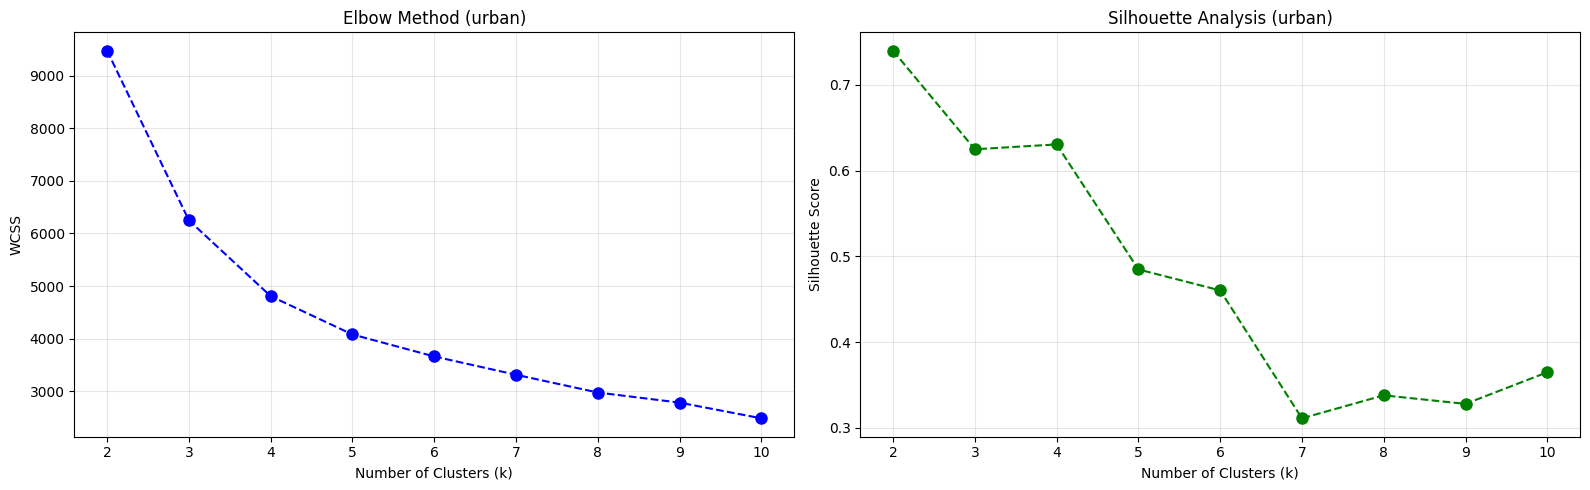

In [27]:
df2022_all = DataLoader(MASTER_DF_FILE).get_data_for_year(year=2022)
pca_engine = UrbanizationPCA(n_components=2)


engine = ClusteringEngine(experiment_name=EXP_KEY, seed=RANDOM_SEED)
engine.load_and_preprocess(df2022_all)
elbow_fig, cluster_df = engine.run_kmeans_tuning()
elbow_fig.show()


After running several experiments, including the one where we treated Porto and Lisbon as outliers ([`notebooks/clustering/02_urbanization_clustering_no_Porto.ipynb`](notebooks/clustering/02_urbanization_clustering_no_Porto.ipynb)), the best (most trustworthy) result was obtained with 6 clusters from the dataset containing all of the municipalities, as shown below.

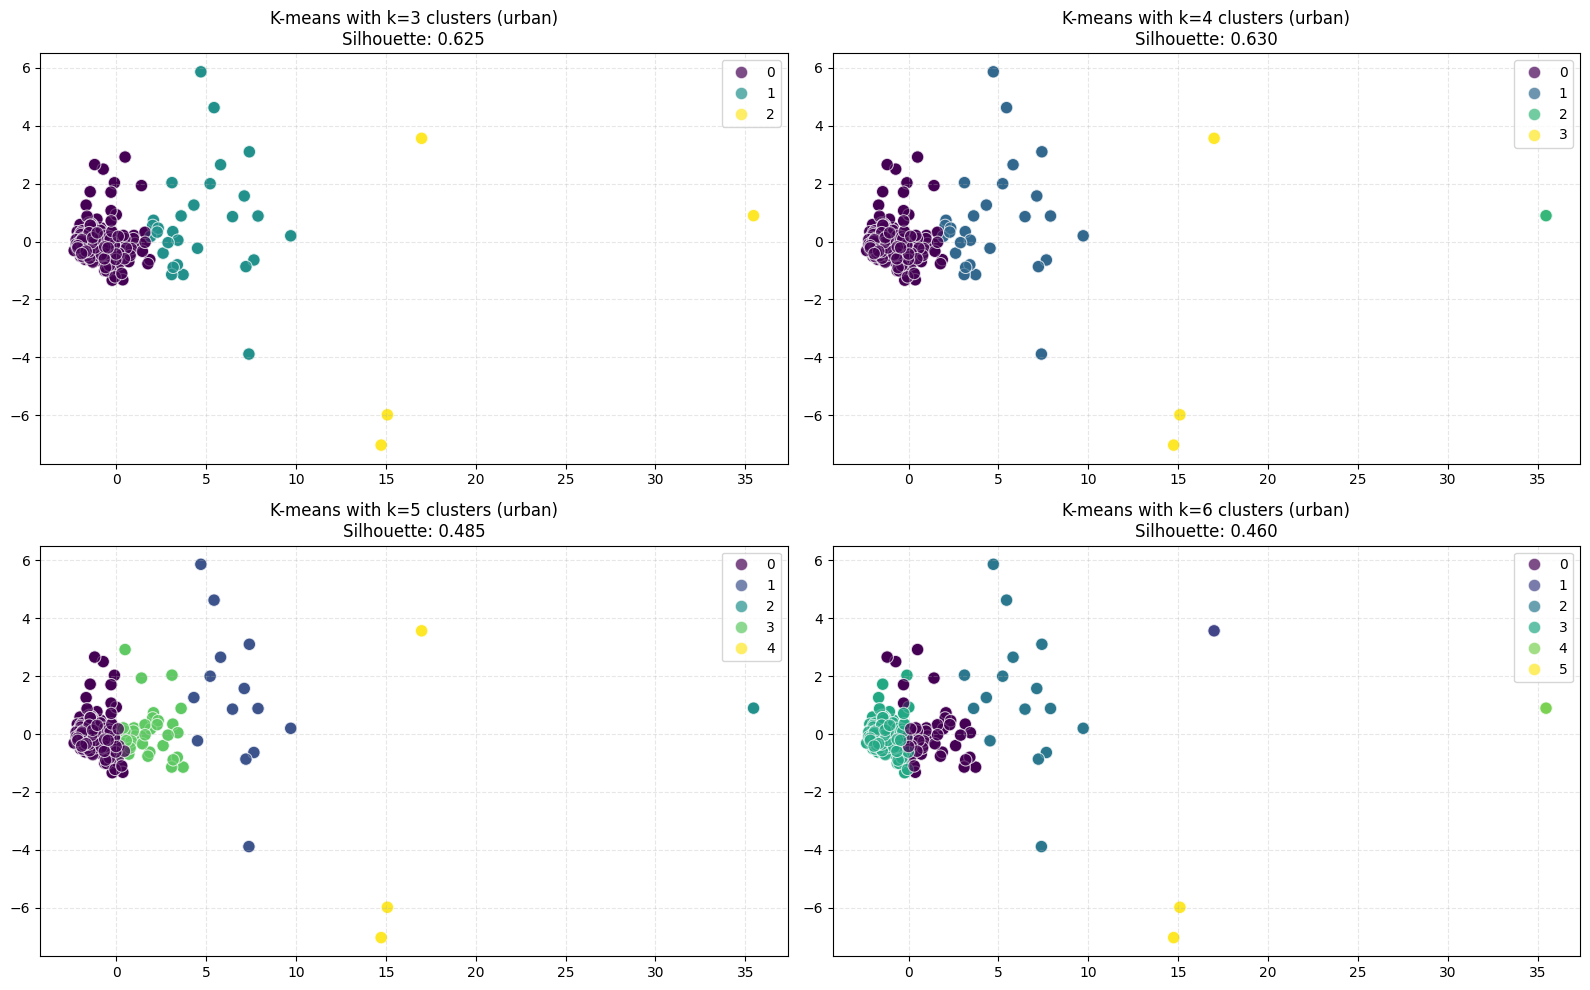

In [28]:
engine.run_batch_training()
df2022_pca = DataLoader(MASTER_DF_FILE).get_data_for_year(year=2022, features=config["features"])
pca_coords = pca_engine.run_pca(df2022_pca).values
fig = engine.plot_saved_models_from_config(pca_data=pca_coords)
fig.show()

As a result of the clustering we've obtained one additional categorical feature, `cluster_urban`. Later on we've decided to run the modeling within the major clusters (Rural, Urban and Suburbs). All of the characteristics of the clusters can be inverstigated in the [`notebooks/clustering/01_urbanization_clustering_all.ipynb`](notebooks/clustering/01_urbanization_clustering_all.ipynb) and [`notebooks/clustering/02_urbanization_clustering_no_Porto.ipynb`](notebooks/clustering/02_urbanization_clustering_no_Porto.ipynb).

We've also conducted the analysis of the age distribution in the obtained clusters. Unfortunately, without additional investigation we didn't come up with any valuable information for the modeling step. Yet the research suggests further questions on the project development. Maybe if we've added a bit more data :)

The age distribution analysis within clusters: [`notebooks/clustering/03_urbanization_age_distribution.ipynb`](notebooks/clustering/03_urbanization_age_distribution.ipynb)

### Modeling

In [24]:
df2= pd.read_csv(URBAN_CLUSTER_FILE, index_col=0)
df2.head()

,municipality,house_price,total_sunshine_h,mean_sunshine_h,windspeed_mean_kmh,total_precipitation_mm,mean_precipitation_mm,windy_days,rainy_days,sunny_days,...,theatre,university,log_price_sqm,< 5,6 - 19,20 - 34,35 - 54,55 - 64,> 65,cluster_urban
0,Arcos de Valdevez,813.0,487.521214,5.299144,9.177174,1405.1,15.272826,0,57,34,...,1.0,0.0,6.700731,583.0,2202.0,2804.0,4844.0,2838.0,7588.0,0
1,Paredes de Coura,723.0,472.135439,5.131907,10.283696,1237.1,13.446739,0,57,34,...,0.0,0.0,6.583409,261.0,1048.0,1172.0,2290.0,1235.0,2703.0,0
2,Ponte da Barca,759.0,499.030875,5.424249,8.804348,1300.5,14.135870,0,57,35,...,1.0,0.0,6.632002,344.0,1326.0,1639.0,2848.0,1634.0,3387.0,0
3,Ponte de Lima,1128.0,513.344253,5.579829,11.211957,1132.9,12.314130,2,58,38,...,1.0,2.0,7.028201,1445.0,5342.0,6654.0,11330.0,6017.0,10342.0,0
4,Valença,945.0,549.046297,5.967895,13.494565,386.7,4.203261,1,54,27,...,1.0,1.0,6.851185,505.0,1857.0,2246.0,3859.0,1918.0,3774.0,0
